In [81]:
import ot as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [82]:
data = pd.read_stata('JPSAERdata.dta')# Assuming 'data' is your DataFrame

# Filter data for 'sample' == 1
sample_data = data[data['sample'] == 1]

# Create dummy variables for 'yymm'
yymm_dummies = pd.get_dummies(sample_data['yymm'], prefix='yymm')

# Convert dummy variable column names to strings
yymm_dummies.columns = yymm_dummies.columns.astype(str)

# Prepare the dataset for regression
reg_data = pd.concat([sample_data, yymm_dummies], axis=1)
# reg_data.dropna(subset=['income'], inplace=True)
#reg_data.dropna(subset=['liqassii'], inplace=True)

# Assuming 'reg_data' is your DataFrame prepared for regression


reg_data['age_squared'] = reg_data['age']**2
# Assuming filteredData is a pandas DataFrame

# Min-Max Normalization for 'income'
reg_data['income_min_max'] = reg_data['income'].apply(
    lambda x: (x - reg_data['income'].min()) / (reg_data['income'].max() - reg_data['income'].min())
)


# Min-Max Normalization for 'age'
reg_data['age_min_max'] = reg_data['age'].apply(
    lambda x: (x - reg_data['age'].min()) / (reg_data['age'].max() - reg_data['age'].min())
)

# Min-Max Normalization for 'age'
reg_data['liqassii_min_max'] = reg_data['liqassii'].apply(
    lambda x: (x - reg_data['liqassii'].min()) / (reg_data['liqassii'].max() - reg_data['liqassii'].min())
)

# Min-Max Normalization for 'age'
reg_data['age_squared_min_max'] = reg_data['age_squared'].apply(
    lambda x: (x - reg_data['age_squared'].min()) / (reg_data['age_squared'].max() - reg_data['age_squared'].min())
)
reg_data['taxreb_0'] = 0
reg_data['taxreb_300'] = 300
reg_data['taxreb_600'] = 600


In [83]:
subset = 'standard'
tax_reb_num =300

In [84]:
synthetic_params = pd.read_csv('IVQR_dcn.csv',header=None)
# Assuming reg_data is your DataFrame and is already defined
# Exogenous variables, excluding the endogenous variable 'income' if it's being instrumented
if subset == 'standard':
    reg_data_exog= reg_data
    reg_data_pre = reg_data
elif subset == 'age_young':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num)  & (reg_data['age'] <= 39)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )   & (reg_data['age'] <= 39)]
elif subset == 'age_old':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num)  & (reg_data['age'] >= 58)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )   & (reg_data['age'] >= 58)]
elif subset == 'income_low':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['income'] <=34928)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )  & (reg_data['income'] <=34928)]
elif subset == 'income_high':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['income'] > 69000)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )  & (reg_data['income'] > 69000)]
elif subset == 'liquid_low':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['liqassii'] <= 1000)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0)   & (reg_data['liqassii'] <= 1000)] 
elif subset == 'liquid_high':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['liqassii'] > 8000)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0)   & (reg_data['liqassii'] > 8000)] 



exog = reg_data_exog[[f'taxreb_{tax_reb_num}','age_min_max','dnumadult',
    'dnumkids' , 'yymm_10102', 'yymm_10103', 'yymm_10104', 'yymm_10105', 'yymm_10106', 'yymm_10107',
                 'yymm_10108', 'yymm_10109', 'yymm_10110', 'yymm_10111', 'yymm_10112',
                 'yymm_10201', 'yymm_10202', 'yymm_10203'
                 ]]
exog_pre = reg_data_pre[['taxreb_0','age_min_max', 'dnumadult',
    'dnumkids' , 'yymm_10102', 'yymm_10103', 'yymm_10104', 'yymm_10105', 'yymm_10106', 'yymm_10107',
                 'yymm_10108', 'yymm_10109', 'yymm_10110', 'yymm_10111', 'yymm_10112',
                 'yymm_10201', 'yymm_10202', 'yymm_10203'
                 ]]


In [85]:
sp_np= synthetic_params.to_numpy()
exog_np = exog.to_numpy()
synthetic_data=exog_np@sp_np
synthetic_data_reshaped = synthetic_data.reshape(1, -1)

In [86]:
exog_pre_np = exog_pre.to_numpy()
synthetic_data_pre = exog_pre_np@sp_np

In [87]:
post_predictions = np.random.choice( synthetic_data_reshaped.flatten(), size=15000, replace=True) 
pre_predictions = np.random.choice( synthetic_data_pre.flatten(), size=15000, replace=True) 
#pre_data = reg_data[(reg_data['itotalreb'] ==0)]
#pre_predictions = pre_data['dcn']

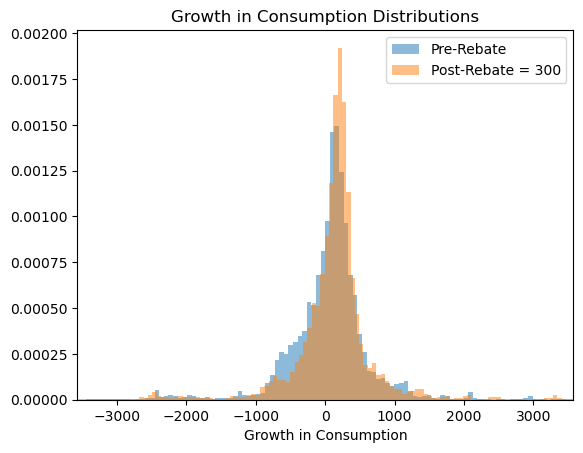

In [88]:
plt.hist(pre_predictions, bins = 1000, alpha=0.5, density=True)
plt.hist(post_predictions, bins = 1000, alpha=0.5, density=True)

# Calculate the 1st and 99th percentiles to use as xlim values
lower_bound, upper_bound = np.percentile(post_predictions, [1, 99])

# Set the x-axis limits to exclude extreme outliers
plt.xlim(lower_bound, upper_bound)
plt.title('Growth in Consumption Distributions')
plt.legend(['Pre-Rebate', f'Post-Rebate = {tax_reb_num}'])
plt.xlabel('Growth in Consumption')
plt.show()



In [89]:
treated   = post_predictions
untreated = pre_predictions
xs = untreated
xt = treated
xs_reshaped = xs.reshape(-1, 1)
xt_reshaped = xt.reshape(-1, 1)

s_array = np.arange(20, 200, 20)
plabebo_statistics = np.zeros((len(s_array),1))
j=0

In [39]:
d= 0.5
placebo_samples = 10
s = np.zeros((placebo_samples,1))
for i in range(placebo_samples):
        xs_placebo_1  = np.random.choice(xs, size=len(xs), replace=True)
        xs_placebo_2  = np.random.choice(xs, size=len(xs), replace=True)

        xs_placebo_1_reshaped = xs_placebo_1.reshape(-1, 1)
        xs_placebo_2_reshaped = xs_placebo_2.reshape(-1, 1)
        Mp = ot.dist(xs_placebo_1_reshaped, xs_placebo_2_reshaped, metric='cityblock')
        M=Mp>d

        # Assuming your dataset is in a numpy array called data

        # Fit KDE to data
        kde_xs1 = gaussian_kde(xs_placebo_1)
        kde_xs2 = gaussian_kde(xs_placebo_2)
        W = ot.emd2(kde_xs1(xs_placebo_1)/np.sum(kde_xs1(xs_placebo_1)), kde_xs2(xs_placebo_2)/np.sum(kde_xs2(xs_placebo_2)), M, numItermax  = 1000000) 
        s[i] = W
        print(i+1)
average_s = np.mean(s)
print(average_s)

1
2
3
4
5
6
7
8
9
10
0.09790032671626318


In [92]:
# Fit KDE to data
d=2
kde_xs = gaussian_kde(xs)
kde_xt = gaussian_kde(xt)
#run ot
Mp = ot.dist(xs_reshaped, xt_reshaped, metric='cityblock')
M=Mp>d
W = ot.emd2(kde_xs(xs)/np.sum(kde_xs(xs)), kde_xt(xt)/np.sum(kde_xt(xt)), M, numItermax  = 1000000) 
W_statistic = W
print(f' Step W Statistic {W} where d={d}')


 Step W Statistic 0.1472592056988129 where d=2
